<a href="https://colab.research.google.com/github/manisht21/object-tracking-cotracker-v3/blob/main/ob2_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === Install & Setup CoTracker ===
!git clone https://github.com/facebookresearch/co-tracker
%cd co-tracker

# Install package in editable mode
!pip install -e .

# Install extra dependencies
!pip install opencv-python einops timm matplotlib moviepy flow_vis

# Create checkpoints directory
!mkdir -p checkpoints
%cd checkpoints

# Download offline (single-window) model
!wget https://huggingface.co/facebook/cotracker3/resolve/main/scaled_offline.pth

# Optional: download online (multi-window) model if needed
!wget https://huggingface.co/facebook/cotracker3/resolve/main/scaled_online.pth

# Return to repo root
%cd ..


fatal: destination path 'co-tracker' already exists and is not an empty directory.
/content/co-tracker
Obtaining file:///content/co-tracker
  Preparing metadata (setup.py) ... done
  Attempting uninstall: cotracker
    Found existing installation: cotracker 3.0
    Uninstalling cotracker-3.0:
      Successfully uninstalled cotracker-3.0
  Running setup.py develop for cotracker
/content/co-tracker/checkpoints
--2025-09-24 12:36:22--  https://huggingface.co/facebook/cotracker3/resolve/main/scaled_offline.pth
Resolving huggingface.co (huggingface.co)... 13.35.202.97, 13.35.202.121, 13.35.202.40, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.97|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cas-bridge.xethub.hf.co/xet-bridge-us/66f28e717967278698d7ebf7/ae694a923aeae71dcdbb5b3ecba33e3c224d2b10b6ffb5dd5ba50c0ab3cdcc45?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Content-Sha256=UNSIGNED-PAYLOAD&X-Amz-Credential=cas%2F20250924%2Fus-east-1%2Fs3%2F

In [ ]:
!git clone https://github.com/facebookresearch/co-tracker.git
%cd co-tracker
!pip install -e .
from cotracker.utils.visualizer import Visualizer, read_video_from_path
from cotracker.predictor import CoTrackerPredictor


fatal: destination path 'co-tracker' already exists and is not an empty directory.
/content/co-tracker/co-tracker
Obtaining file:///content/co-tracker/co-tracker
  Preparing metadata (setup.py) ... done
  Attempting uninstall: cotracker
    Found existing installation: cotracker 3.0
    Uninstalling cotracker-3.0:
      Successfully uninstalled cotracker-3.0
  Running setup.py develop for cotracker


In [ ]:
%cd ..
import os
import torch

from base64 import b64encode
from cotracker.utils.visualizer import Visualizer, read_video_from_path
from IPython.display import HTML

/content/co-tracker


In [ ]:
video = read_video_from_path('/content/drive/MyDrive/output_video.mp4')
video = torch.from_numpy(video).permute(0, 3, 1, 2)[None].float()

In [ ]:
def show_video(video_path):
    video_file = open(video_path, "r+b").read()
    video_url = f"/content/drive/MyDrive/output_video.mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width=""640 height="360" autoplay loop controls><source src="{video_url}"></video>""")

In [ ]:
video = read_video_from_path("/content/drive/MyDrive/output_video.mp4")

# Convert to torch tensor: [1, T, 3, H, W]
video = torch.from_numpy(video).permute(0, 3, 1, 2)[None].float() / 255.0

print("Video tensor:", video.shape)

Video tensor: torch.Size([1, 290, 3, 360, 640])


In [ ]:
show_video("/content/drive/MyDrive/output_video.mp4")

In [ ]:
import torch
import imageio.v3 as iio
import cv2

# Load video
video_path = "/content/drive/MyDrive/output_video.mp4"
frames = iio.imread(video_path, plugin="FFMPEG")  # shape (T, H, W, C)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize model
cotracker = torch.hub.load("facebookresearch/co-tracker", "cotracker3_offline").to(device)
cotracker.eval()

chunk_size = 50  # process 50 frames at a time
grid_size = 5    # smaller grid size to save memory

pred_tracks_list = []
pred_visibility_list = []

for i in range(0, len(frames), chunk_size):
    chunk = frames[i:i+chunk_size]

    # Convert to tensor (B, T, C, H, W)
    chunk_tensor = torch.tensor(chunk).permute(0,3,1,2)[None].float().to(device)

    with torch.no_grad():
        tracks, visibility = cotracker(chunk_tensor, grid_size=grid_size)

    pred_tracks_list.append(tracks.cpu())
    pred_visibility_list.append(visibility.cpu())

# Concatenate all chunks
pred_tracks = torch.cat(pred_tracks_list, dim=1)
pred_visibility = torch.cat(pred_visibility_list, dim=1)

print("Final tracks shape:", pred_tracks.shape)
print("Final visibility shape:", pred_visibility.shape)


Using cache found in /root/.cache/torch/hub/facebookresearch_co-tracker_main


Final tracks shape: torch.Size([1, 290, 25, 2])
Final visibility shape: torch.Size([1, 290, 25])


In [ ]:
import cv2
import numpy as np

# Convert frames to BGR for OpenCV
frames_bgr = [cv2.cvtColor(f, cv2.COLOR_RGB2BGR) for f in frames]

# Get tracks as numpy
tracks = pred_tracks[0].numpy()      # shape (T, N, 2)
visibility = pred_visibility[0].numpy()  # shape (T, N)

# Choose colors for each track
colors = [tuple(np.random.randint(0, 255, 3).tolist()) for _ in range(tracks.shape[1])]

# Draw tracks on frames
for t, frame in enumerate(frames_bgr):
    for i in range(tracks.shape[1]):
        if visibility[t, i] > 0.5:  # only draw if visible
            x, y = int(tracks[t, i, 0]), int(tracks[t, i, 1])
            cv2.circle(frame, (x, y), 4, colors[i], -1)
            # draw line for trajectory
            if t > 0:
                prev_x, prev_y = int(tracks[t-1, i, 0]), int(tracks[t-1, i, 1])
                cv2.line(frame, (prev_x, prev_y), (x, y), colors[i], 2)

# Save output video
out_path = "/content/drive/MyDrive/output_tracked 1.mp4"
height, width = frames_bgr[0].shape[:2]
out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), 25, (width, height))

for frame in frames_bgr:
    out.write(frame)
out.release()

print("Saved tracked video at:", out_path)


Saved tracked video at: /content/drive/MyDrive/output_tracked 1.mp4


In [ ]:
from cotracker.utils.visualizer import Visualizer
import os

# Create save directory
save_dir = "/content/drive/MyDrive/saved_videos"
os.makedirs(save_dir, exist_ok=True)

# Initialize Visualizer
vis = Visualizer(save_dir=save_dir, pad_value=120, linewidth=3)

# Visualize and save the video
# filename can be anything you want
vis.visualize(video=video, tracks=pred_tracks, visibility=pred_visibility, filename="output_tracked.mp4")

print(f"Tracked video saved at: {save_dir}/output_tracked.mp4")


Video saved to /content/drive/MyDrive/saved_videos/output_tracked.mp4.mp4
Tracked video saved at: /content/drive/MyDrive/saved_videos/output_tracked.mp4


In [ ]:
show_video('/content/drive/MyDrive/saved_videos/output_tracked.mp4.mp4')

In [ ]:
import cv2
import numpy as np

def overlay_tracks(video, tracks, visibility, out_path="overlay_output.mp4"):
    # video: (T, H, W, C) uint8 numpy
    T, H, W, C = video.shape
    num_points = tracks.shape[1]

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(out_path, fourcc, 30, (W, H))

    for t in range(T):
        frame = video[t].copy()

        for i in range(num_points):
            if visibility[0, i, t]:   # only draw if visible
                x, y = tracks[0, i, t]
                cv2.circle(frame, (int(x), int(y)), 4, (0, 0, 255), -1)

        writer.write(frame)

    writer.release()
    print(f"Saved with overlay: {out_path}")


In [ ]:
import imageio
import torch
import numpy as np

# Reload the video from file
video_path = "/content/drive/MyDrive/output_video.mp4"   # <-- replace with your video file
reader = imageio.get_reader(video_path)

frames = []
for frame in reader:
    frames.append(frame)
reader.close()

# Convert to numpy (T, H, W, C)
video_np = np.array(frames)

# Also convert to torch (1, T, C, H, W) if you need model input again
video_cpu = torch.from_numpy(video_np).permute(0, 3, 1, 2).unsqueeze(0).float()

print("Reloaded video_np:", video_np.shape)   # (T, H, W, C)
print("Reloaded video_cpu:", video_cpu.shape) # (1, T, C, H, W)
# Compute safe length
T_video = video_np.shape[0]
T_pred = pred_tracks.shape[2]
T = min(T_video, T_pred)

# Trim both video and predictions
video_np = video_np[:T]
pred_tracks_np = pred_tracks[:, :, :T].cpu().numpy()
pred_visibility_np = pred_visibility[:, :, :T].cpu().numpy()

# Now overlay tracked points safely
overlay_tracks(
    video_np,
    pred_tracks_np,
    pred_visibility_np,
    "ball_tracked.mp4"
)



Reloaded video_np: (290, 360, 640, 3)
Reloaded video_cpu: torch.Size([1, 290, 3, 360, 640])
Saved with overlay: ball_tracked.mp4


In [ ]:
overlay_tracks(
    video_np,
    pred_tracks.cpu().numpy(),
    pred_visibility.cpu().numpy(),
    "/content/drive/MyDrive/ball_tracked.mp4"   # <-- save to Drive
)


Saved with overlay: /content/drive/MyDrive/ball_tracked.mp4


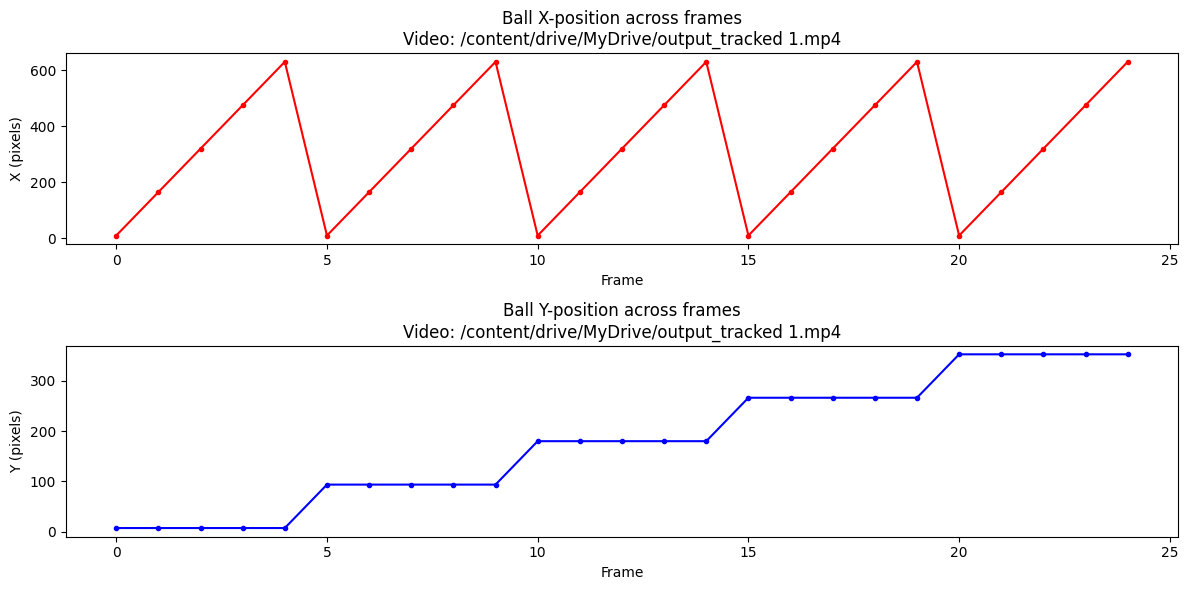

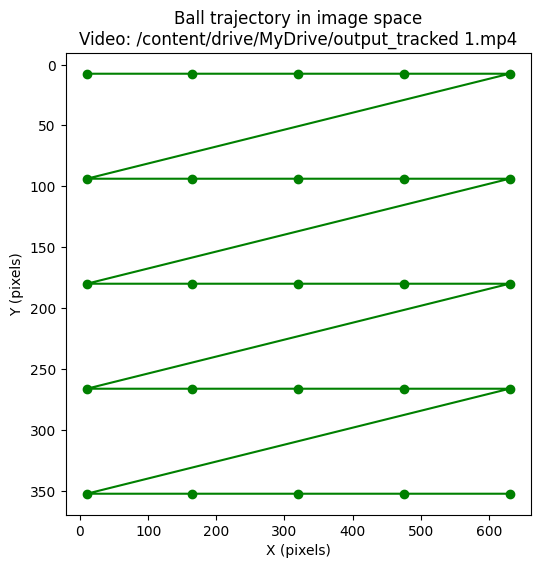

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Path to the video from which plots are generated
video_path = "/content/drive/MyDrive/output_tracked 1.mp4"  # <-- replace with your actual video path

# Assuming pred_tracks shape: [1, N, T, 2]  (batch, points, time, xy)
# and pred_visibility: [1, N, T]

tracks_np = pred_tracks.cpu().numpy()[0]         # (N, T, 2)
visibility_np = pred_visibility.cpu().numpy()[0]  # (N, T)

# Choose the first point (ball)
ball_track = tracks_np[0]         # (T, 2)
ball_visible = visibility_np[0]   # (T,)

frames = np.arange(ball_track.shape[0])

# Plot X and Y over time (only when visible)
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(frames[ball_visible], ball_track[ball_visible, 0], 'r.-')
plt.title(f"Ball X-position across frames\nVideo: {video_path}")
plt.xlabel("Frame")
plt.ylabel("X (pixels)")

plt.subplot(2,1,2)
plt.plot(frames[ball_visible], ball_track[ball_visible, 1], 'b.-')
plt.title(f"Ball Y-position across frames\nVideo: {video_path}")
plt.xlabel("Frame")
plt.ylabel("Y (pixels)")

plt.tight_layout()
plt.show()

# Optional: 2D trajectory (path of ball in image space)
plt.figure(figsize=(6,6))
plt.plot(ball_track[ball_visible,0], ball_track[ball_visible,1], 'go-')
plt.gca().invert_yaxis()  # image coords: top-left origin
plt.title(f"Ball trajectory in image space\nVideo: {video_path}")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.show()


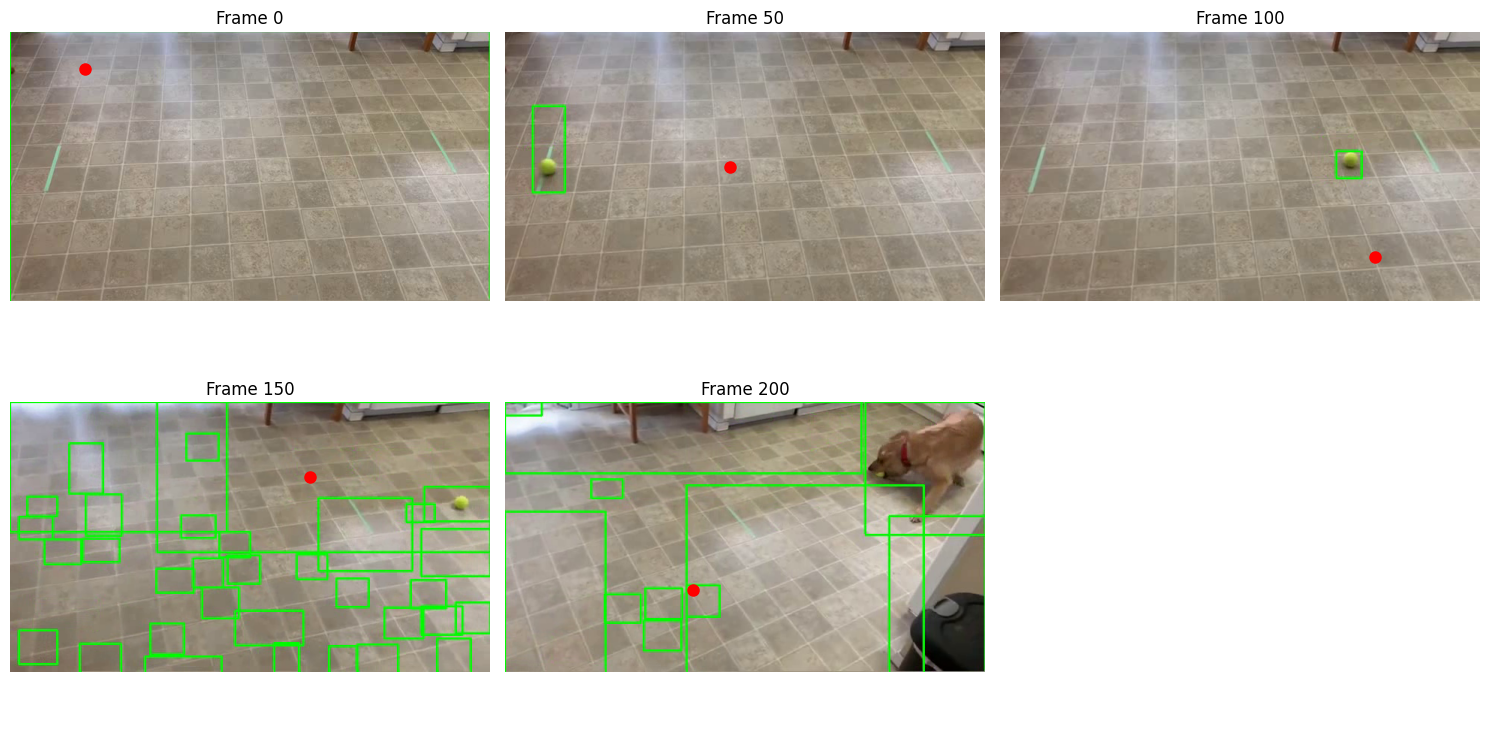

In [ ]:
import torch
import matplotlib.pyplot as plt
import imageio

# Video path
video_path = "/content/drive/MyDrive/output_video.mp4"
video_np = imageio.v3.imread(video_path)  # (num_frames, H, W, 3)
H, W = video_np.shape[1], video_np.shape[2]

# Manually selected points: [frame_index, x, y]
queries = torch.tensor([
    [0., 100., 50.],
    [50., 300., 180.],
    [100., 500., 300.],
    [150., 400., 100.],
    [200., 250., 250.]
])

if torch.cuda.is_available():
    queries = queries.cuda()

frame_numbers = queries[:,0].int().tolist()

# Create subplots for the queries
fig, axs = plt.subplots(2, 3, figsize=(15,8))
axs = axs.flatten()

for i, (query, frame_number) in enumerate(zip(queries, frame_numbers)):
    ax = axs[i]

    if frame_number < video_np.shape[0]:
        frame = video_np[frame_number]
        ax.imshow(frame)

    # Overlay the manually selected point
    ax.plot(query[1].item(), query[2].item(), 'ro', markersize=8)
    ax.set_title(f"Frame {frame_number}")
    ax.set_xlim(0, W)
    ax.set_ylim(H, 0)  # invert y-axis
    ax.axis('off')

# Hide any unused subplots
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


Object-centric video saved at: /content/drive/MyDrive/ball_object_centric_corrected.mp4


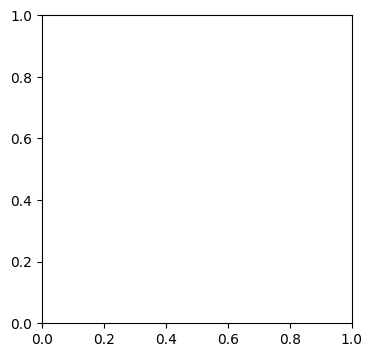

In [ ]:
import imageio
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

# ----------------------------
# Video & CoTracker paths
# ----------------------------
video_path = "/content/drive/MyDrive/output_tracked 1.mp4"
output_path = "/content/drive/MyDrive/ball_object_centric_corrected.mp4" # Changed output path

# Read video
video_np = imageio.v3.imread(video_path)

# Remove extra batch dim if exists
if video_np.ndim == 5:
    video_np = video_np[0]

H, W = video_np.shape[1], video_np.shape[2]
fps = 30  # Set your video's FPS
start_sec = 2
start_frame = int(start_sec * fps)
end_frame = video_np.shape[0]

# ----------------------------
# Predicted tracks & visibility
# ----------------------------
# Make sure pred_tracks and pred_visibility are defined before this
# Example dummy data:
# pred_tracks = torch.randn(1, 100, 150, 2) * 100
# pred_visibility = torch.rand(1, 100, 150) > 0.5

tracks_np = pred_tracks.cpu().numpy()[0]
visibility_np = pred_visibility.cpu().numpy()[0]
num_points = tracks_np.shape[0]

crop_size = 50
trajectories = [[] for _ in range(num_points)]

# ----------------------------
# Setup video writer
# ----------------------------
fig, ax = plt.subplots(figsize=(4, 4))
metadata = dict(title='Ball Object-Centric', artist='CoTracker', comment='Ball trajectory')
writer = FFMpegWriter(fps=fps, metadata=metadata)

with writer.saving(fig, output_path, dpi=150):
    for i in range(start_frame, min(end_frame, tracks_np.shape[1])):
        ax.clear()

        # --- START: MODIFIED LOGIC ---

        # 1. Find all visible points in the current frame
        visible_points_indices = [p for p in range(num_points) if visibility_np[p, i]]

        # If no points are visible, just grab an empty frame and continue
        if not visible_points_indices:
            # You could show a black screen or the full frame
            ax.imshow(np.zeros((crop_size*2, crop_size*2, 3), dtype=np.uint8))
            ax.axis('off')
            ax.set_title(f"Frame {i} - No Points Visible")
            writer.grab_frame()
            continue

        # 2. Calculate the centroid (average position) of visible points
        visible_tracks = tracks_np[visible_points_indices, i, :]
        center_x, center_y = np.mean(visible_tracks, axis=0)
        center_x, center_y = int(center_x), int(center_y)

        # 3. Create ONE crop around the centroid
        x1 = max(0, center_x - crop_size)
        x2 = min(W, center_x + crop_size)
        y1 = max(0, center_y - crop_size)
        y2 = min(H, center_y + crop_size)

        frame_crop = video_np[i, y1:y2, x1:x2, :] if video_np.ndim == 4 else video_np[y1:y2, x1:x2, :]

        # 4. Display the single cropped image
        ax.imshow(frame_crop)

        # 5. Draw all trajectories relative to this new crop
        for p in visible_points_indices:
            # Update the trajectory list for the current point
            x_p, y_p = int(tracks_np[p, i, 0]), int(tracks_np[p, i, 1])
            trajectories[p].append((x_p, y_p))

            # Convert trajectory coordinates to be relative to the crop
            traj = np.array(trajectories[p])
            traj_in_crop = np.array([[tx - x1, ty - y1] for tx, ty in traj])

            if len(traj_in_crop) > 1:
                ax.plot(traj_in_crop[:, 0], traj_in_crop[:, 1], 'yellow', linewidth=2)

        # --- END: MODIFIED LOGIC ---

        ax.axis('off')
        ax.set_title(f"Frame {i}")
        writer.grab_frame()

print(f"Object-centric video saved at: {output_path}")

In [ ]:
import imageio
import torch

video_path = "/content/drive/MyDrive/output_video.mp4"
video_np = imageio.v3.imread(video_path)  # (T, H, W, 3)

# Convert to torch tensor [1, T, C, H, W]
video_tensor = torch.from_numpy(video_np).permute(0, 3, 1, 2).unsqueeze(0).float()


In [ ]:
# Example: manually annotated points
queries = torch.tensor([
    [0., 100., 50.],    # frame 0, top-left
    [50., 300., 180.],  # frame 50
    [100., 500., 300.], # frame 100
    [150., 400., 100.], # frame 150
    [200., 250., 250.]  # frame 200
])

if torch.cuda.is_available():
    video_tensor = video_tensor.cuda()
    queries = queries.cuda()


In [ ]:
from cotracker.predictor import CoTrackerPredictor

model = CoTrackerPredictor(checkpoint="/content/co-tracker/checkpoints/scaled_offline.pth")


Loaded video with 290 frames, size 360x640


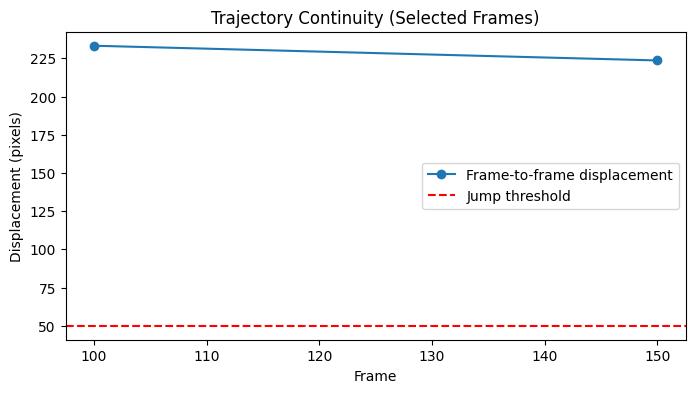

Displacement from frame 50 to 100: 233.24 pixels
Displacement from frame 100 to 150: 223.61 pixels
Displacement from frame 50 to 100: 233.24 pixels
Displacement from frame 100 to 150: 223.61 pixels


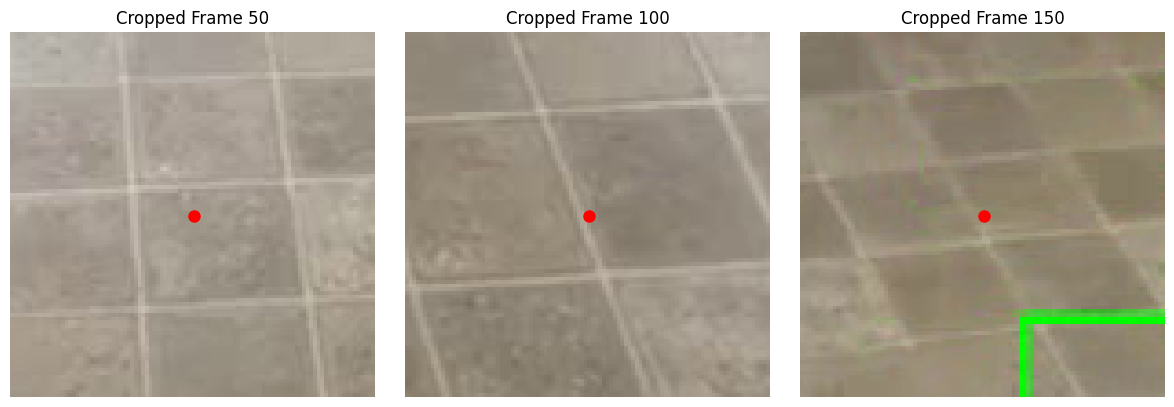

In [ ]:
import torch
import imageio
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Step 1: Load video
# ----------------------------
video_path = "/content/drive/MyDrive/output_video.mp4"
video_np = imageio.v3.imread(video_path)  # (num_frames, H, W, 3)
T, H, W, _ = video_np.shape
print(f"Loaded video with {T} frames, size {H}x{W}")

# ----------------------------
# Step 2: Define manually selected points (visible frames only)
# ----------------------------
queries = torch.tensor([
    [50., 300., 180.],
    [100., 500., 300.],
    [150., 400., 100.]
])

frame_numbers = queries[:,0].int().tolist()

# ----------------------------
# Step 3: Plot frames with object overlay
# ----------------------------
# Only use visible frames
positions = queries[:,1:].numpy()  # x, y coordinates
frames = queries[:,0].int().numpy()  # 50, 100, 150

# Compute frame-to-frame displacement
displacements = np.linalg.norm(np.diff(positions, axis=0), axis=1)

# Plot graph
plt.figure(figsize=(8,4))
plt.plot(frames[1:], displacements, 'o-', label='Frame-to-frame displacement')
plt.axhline(50, color='r', linestyle='--', label='Jump threshold')
plt.xlabel('Frame')
plt.ylabel('Displacement (pixels)')
plt.title('Trajectory Continuity (Selected Frames)')
plt.legend()
plt.show()

# Print values
for i, d in enumerate(displacements):
    print(f"Displacement from frame {frames[i]} to {frames[i+1]}: {d:.2f} pixels")


# ----------------------------
# Step 4: Quantitative analysis - displacement
# ----------------------------
positions = queries[:,1:].numpy()  # x,y coordinates
displacements = np.linalg.norm(np.diff(positions, axis=0), axis=1)

for i, d in enumerate(displacements):
    print(f"Displacement from frame {frame_numbers[i]} to {frame_numbers[i+1]}: {d:.2f} pixels")

# ----------------------------
# Step 5: Object-centric cropped visualization
# ----------------------------
crop_size = 50  # pixels around object
fig, axs = plt.subplots(1, 3, figsize=(12,4))

for i, (query, frame_number) in enumerate(zip(queries, frame_numbers)):
    x, y = int(query[1].item()), int(query[2].item())
    x1, x2 = max(0, x - crop_size), min(W, x + crop_size)
    y1, y2 = max(0, y - crop_size), min(H, y + crop_size)

    crop = video_np[frame_number, y1:y2, x1:x2, :]

    ax = axs[i]
    ax.imshow(crop)
    ax.plot(crop_size, crop_size, 'ro', markersize=8)  # object at center of crop
    ax.set_title(f"Cropped Frame {frame_number}")
    ax.axis('off')

plt.tight_layout()
plt.show()


Loaded video: 290 frames, 360x640, 25.0 FPS


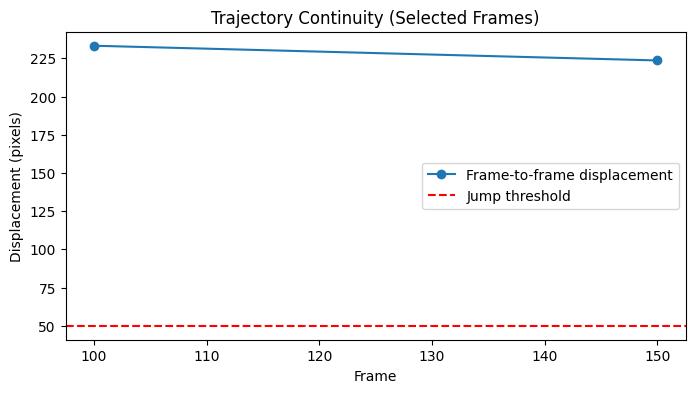

Displacement plot saved at: /content/drive/MyDrive/saved_videos/displacement_plot.png
Displacement from frame 50 to 100: 233.24 px
Displacement from frame 100 to 150: 223.61 px
Cropped frame 50 saved at: /content/drive/MyDrive/saved_videos/cropped_frame_50.png
Cropped frame 100 saved at: /content/drive/MyDrive/saved_videos/cropped_frame_100.png
Cropped frame 150 saved at: /content/drive/MyDrive/saved_videos/cropped_frame_150.png
Object-centric video saved at: /content/drive/MyDrive/saved_videos/object_centric_tracked.mp4


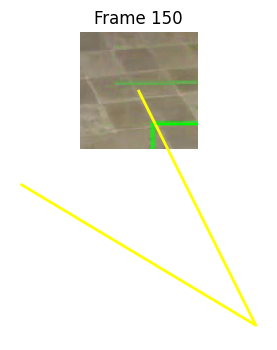

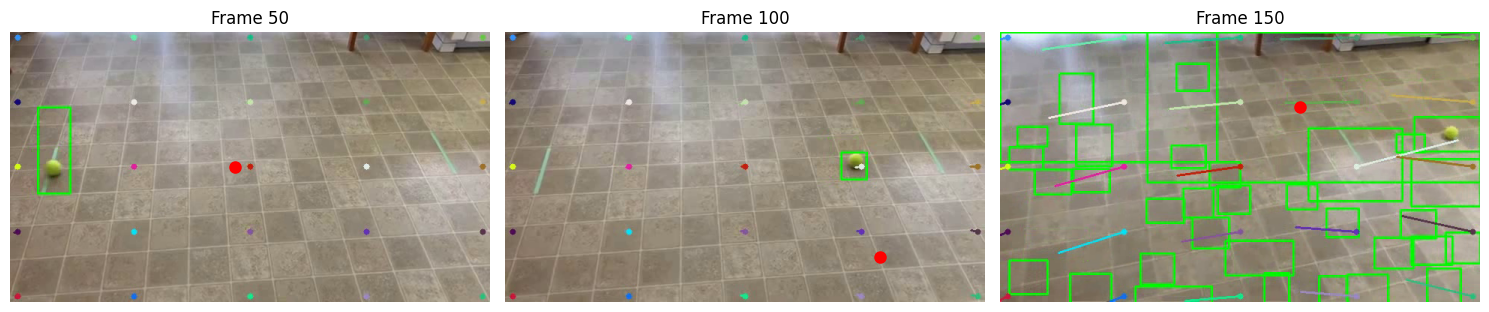

Overlay frames plot saved at: /content/drive/MyDrive/saved_videos/selected_frames_overlay.png


In [ ]:
import torch
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import os

# ----------------------------
# Step 0: Create folder in Drive to save plots
# ----------------------------
save_dir = "/content/drive/MyDrive/saved_videos"
os.makedirs(save_dir, exist_ok=True)

# ----------------------------
# Step 1: Load Tracked Video
# ----------------------------
video_path = "/content/drive/MyDrive/output_tracked 1.mp4"
video_reader = imageio.get_reader(video_path, 'ffmpeg')
num_frames = video_reader.get_length()

video_np = []
for frame in video_reader:
    video_np.append(frame)
video_np = np.array(video_np)
T, H, W, _ = video_np.shape
fps = video_reader.get_meta_data()['fps']
print(f"Loaded video: {T} frames, {H}x{W}, {fps} FPS")

# ----------------------------
# Step 2: Define manually tracked points (queries)
# ----------------------------
queries = torch.tensor([
    [50., 300., 180.],
    [100., 500., 300.],
    [150., 400., 100.]
])
frames_visible = queries[:,0].int().numpy()
positions = queries[:,1:].numpy()

# Visibility mask
visibility = np.zeros((1, T))
for f in frames_visible:
    visibility[0, f] = 1

# ----------------------------
# Step 3: Quantitative Analysis - Displacement
# ----------------------------
displacements = np.zeros(len(frames_visible)-1)
for i in range(len(frames_visible)-1):
    displacements[i] = np.linalg.norm(positions[i+1] - positions[i])

# Plot displacement
plt.figure(figsize=(8,4))
plt.plot(frames_visible[1:], displacements, 'o-', label='Frame-to-frame displacement')
plt.axhline(50, color='r', linestyle='--', label='Jump threshold')
plt.xlabel('Frame')
plt.ylabel('Displacement (pixels)')
plt.title('Trajectory Continuity (Selected Frames)')
plt.legend()
displacement_path = os.path.join(save_dir, "displacement_plot.png")
plt.savefig(displacement_path)
plt.show()
print(f"Displacement plot saved at: {displacement_path}")

for i, d in enumerate(displacements):
    print(f"Displacement from frame {frames_visible[i]} to {frames_visible[i+1]}: {d:.2f} px")

# ----------------------------
# Step 4: Object-Centric Cropped Frames
# ----------------------------
crop_size = 50
output_path = os.path.join(save_dir, "object_centric_tracked.mp4")

fig, ax = plt.subplots(figsize=(4,4))
metadata = dict(title='Object-Centric Video', artist='CoTracker', comment='Trajectory overlay')
writer = FFMpegWriter(fps=fps, metadata=metadata)

trajectories = [[] for _ in range(1)]  # one object

with writer.saving(fig, output_path, dpi=150):
    for i in frames_visible:
        ax.clear()
        x, y = int(positions[np.where(frames_visible==i)[0][0]][0]), int(positions[np.where(frames_visible==i)[0][0]][1])
        trajectories[0].append((x, y))

        # Crop around object
        x1, x2 = max(0, x - crop_size), min(W, x + crop_size)
        y1, y2 = max(0, y - crop_size), min(H, y + crop_size)
        frame_crop = video_np[i, y1:y2, x1:x2, :]

        ax.imshow(frame_crop)
        traj = np.array(trajectories[0])
        traj_in_crop = np.array([[tx - (x - crop_size), ty - (y - crop_size)] for tx, ty in traj])
        if len(traj_in_crop) > 1:
            ax.plot(traj_in_crop[:,0], traj_in_crop[:,1], 'yellow', linewidth=2)

        ax.axis('off')
        ax.set_title(f"Frame {i}")
        writer.grab_frame()

        # Save each cropped frame as image
        cropped_frame_path = os.path.join(save_dir, f"cropped_frame_{i}.png")
        plt.imsave(cropped_frame_path, frame_crop)
        print(f"Cropped frame {i} saved at: {cropped_frame_path}")

print(f"Object-centric video saved at: {output_path}")

# ----------------------------
# Step 5: Selected Frames with Overlay
# ----------------------------
fig, axs = plt.subplots(1, len(frames_visible), figsize=(15,5))
for i, frame_idx in enumerate(frames_visible):
    ax = axs[i]
    frame = video_np[frame_idx]
    ax.imshow(frame)
    ax.plot(positions[i,0], positions[i,1], 'ro', markersize=8)
    ax.set_title(f"Frame {frame_idx}")
    ax.axis('off')

overlay_frames_path = os.path.join(save_dir, "selected_frames_overlay.png")
plt.tight_layout()
plt.savefig(overlay_frames_path)
plt.show()
print(f"Overlay frames plot saved at: {overlay_frames_path}")
